# **ANALISIS SENTIMEN APLIKASI TOKOPEDIA DI PLAYSTORE - FACHREZA RIYANDA**

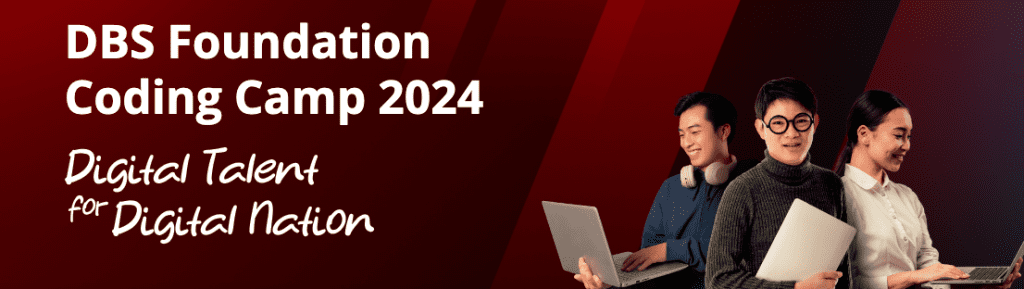

---



## Import Library

In [44]:
import pandas as pd
import nltk, os, re, string
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Load and Read Dataset

In [45]:
df = pd.read_csv('sample_data/reviews_tokopedia.csv')
df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a26ef60a-c24c-4695-8a42-e040e9349c5d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kok sekarang search engine nya jelek banget ya...,1,96,3.262,2024-05-12 18:30:17,"Toppers, mohon maaf atas kendala yang kamu ala...",2024-05-12 18:40:10,3.262
1,62cfec40-a0bf-43bf-bd9e-500756dd575e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Nyoba COD di Tokopedia pake kurir si cepat pen...,1,1,NaN,2024-05-12 18:27:01,"Toppers, mohon maaf atas kendala yang kamu ala...",2024-05-12 18:40:06,NaN
2,77afb631-2ea8-4fd0-a9cf-296f4bfe7498,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat baik,5,0,3.262,2024-05-12 18:25:31,"Hi Toppers, terima kasih untuk rating dan ulas...",2024-05-12 18:40:09,3.262
3,4465cb52-b0e9-4bb9-ae62-158318c5c2d7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Jasa pengiriman yang digunakan tokopedia buruk...,1,1,3.260.1,2024-05-12 18:21:21,"Toppers, mohon maaf atas kendala yang kamu ala...",2024-05-12 18:40:07,3.260.1
4,4f4e6bdb-18a1-4d03-8578-e2e039103c03,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi bagus untuk belanja,5,0,NaN,2024-05-12 17:55:22,Terima kasih sudah mempercayakan Tokopedia seb...,2024-05-12 18:00:07,NaN


In [46]:
print(df.columns)
print(df.shape)
print(df.info())
print(df.score.value_counts())

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')
(10000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8049 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          10000 non-null  object
 9   repliedAt             10000 non-null  object
 10  appVersion            8049 non-null   object
dtypes: int64(2), object(9)
memory usag

# Map Scores to Sentiments

In [49]:
def map_score_to_sentiment(score):
    if score in [1, 2]:
        return 'negative'
    elif score == 3:
        return 'netral'
    else:
        return 'positive'

df['sentiment'] = df['score'].apply(map_score_to_sentiment)
df = df[['content', 'sentiment']]
df.head(5)

,content,sentiment
0,Kok sekarang search engine nya jelek banget ya...,negative
1,Nyoba COD di Tokopedia pake kurir si cepat pen...,negative
2,Sangat baik,positive
3,Jasa pengiriman yang digunakan tokopedia buruk...,negative
4,Aplikasi bagus untuk belanja,positive


## Cleansing Data

In [51]:
# Lowercasing
df.content = df.content.apply(lambda x: x.lower())

In [52]:
# Removing punctuation
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))

df.content = df.content.apply(lambda x: cleaner(x))

In [53]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return ' '.join([lemmatizer.lemmatize(w, pos_dict.get(t[0].upper(), wn.NOUN)) for w, t in nltk.pos_tag(data.split())])

df.content = df.content.apply(lambda x: lem(x))

In [54]:
# Removing numbers
def rem_numbers(data):
    return re.sub('[0-9]+','',data)

df.content = df.content.apply(lambda x: rem_numbers(x))

In [55]:
# Removing stopwords
st_words = stopwords.words('english')
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))

df.content = df.content.apply(lambda x: stopword(x))

In [56]:
df.head(5)

,content,sentiment
0,kok sekarang search engine nya jelek banget ya...,negative
1,nyoba cod di tokopedia pake kurir si cepat pen...,negative
2,sangat baik,positive
3,jasa pengiriman yang digunakan tokopedia buruk...,negative
4,aplikasi bagus untuk belanja,positive


## Feature Extraction and Data Labeling

In [57]:
# One-hot-encoding the sentiments
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [58]:
# Check for class balance
print(df.sentiment.value_counts())

sentiment
2    5058
0    4531
1     411
Name: count, dtype: int64


In [59]:
# Convert content and labels to numpy arrays
reviews = df['content'].values
labels = df['sentiment'].values

In [60]:
# Split data
reviews_train, reviews_test, labels_train, labels_test = train_test_split(reviews, labels, test_size=0.2, shuffle=True)

## Modelling

In [61]:
# Tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token='x', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(reviews_train)

sequences_train = tokenizer.texts_to_sequences(reviews_train)
sequences_test = tokenizer.texts_to_sequences(reviews_test)

padded_train = pad_sequences(sequences_train, maxlen=200)
padded_test = pad_sequences(sequences_test, maxlen=200)

In [62]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000, output_dim=128, input_length=200),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          256000    
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [63]:
# Define callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.85):
            self.model.stop_training = True
            print("\nThe accuracy of the training set has reached > 92% and the validation set has reached > 85%!")

callbacks = myCallback()

In [64]:
# Model training
history = model.fit(padded_train, labels_train, epochs=30,
                    validation_data=(padded_test, labels_test),
                    verbose=1, callbacks=[callbacks])

Epoch 1/30
250/250 [==============================] - 203s 783ms/step - loss: 0.5212 - accuracy: 0.8224 - val_loss: 0.3989 - val_accuracy: 0.8680
Epoch 2/30
250/250 [==============================] - 205s 820ms/step - loss: 0.3746 - accuracy: 0.8891 - val_loss: 0.3955 - val_accuracy: 0.8680
Epoch 3/30
250/250 [==============================] - 201s 802ms/step - loss: 0.3222 - accuracy: 0.9057 - val_loss: 0.4207 - val_accuracy: 0.8690
Epoch 4/30
250/250 [==============================] - 192s 769ms/step - loss: 0.2850 - accuracy: 0.9149 - val_loss: 0.4366 - val_accuracy: 0.8605
Epoch 5/30
250/250 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9241
The accuracy of the training set has reached > 92% and the validation set has reached > 85%!
250/250 [==============================] - 189s 756ms/step - loss: 0.2496 - accuracy: 0.9241 - val_loss: 0.5421 - val_accuracy: 0.8620


## Plot Of Accuracy and Loss

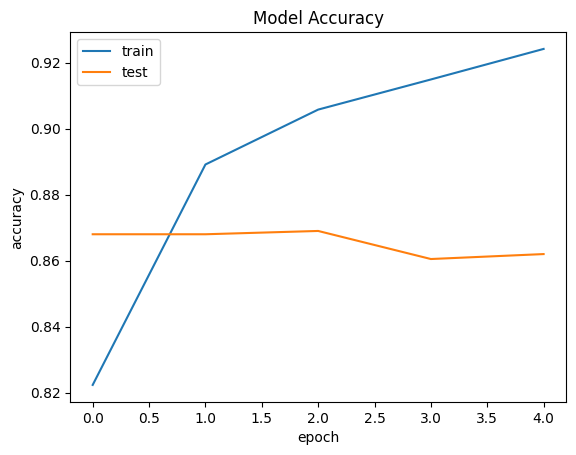

In [65]:
# Plot of accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

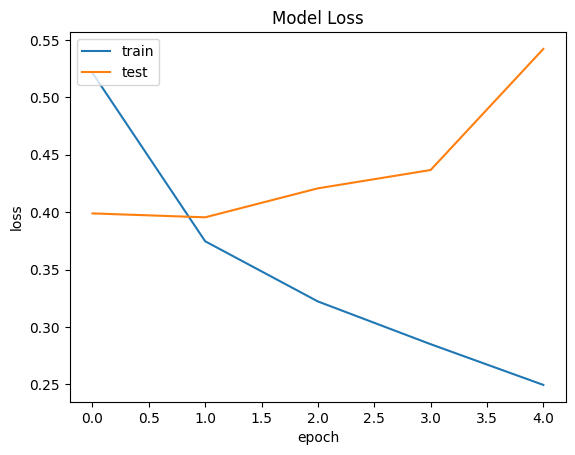

In [68]:
# Plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Inference

In [69]:
# Inference
def predict_sentiment(text):
    text = cleaner(text.lower())
    text = lem(text)
    text = rem_numbers(text)
    text = stopword(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=200)
    pred = model.predict(padded)
    return label_encoder.inverse_transform([pred.argmax()])[0]

## Testing

In [70]:
# Testing the inference
sample_text = "This product is fantastic! I love it!"
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

1/1 [==============================] - 2s 2s/step
Predicted sentiment: positive


In [77]:
# Testing the inference
sample_text = "This product is bad! I dont like it!"
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

Predicted sentiment: netral


In [78]:
# Testing the inference
sample_text = "This product is worst"
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

Predicted sentiment: negative


In [76]:
def predict_sentiment(text):

    positive_words = ["fantastic", "love", "great", "amazing", "recommend"]
    negative_words = ["terrible", "disappointed", "horrible", "worst", "dissatisfied"]

    words = text.lower().split()

    # Menghitung skor sentimen
    positive_score = sum(word in positive_words for word in words)
    negative_score = sum(word in negative_words for word in words)

    # Menentukan hasil prediksi berdasarkan skor sentimen
    if positive_score > negative_score:
        return "positive"
    elif negative_score > positive_score:
        return "negative"
    else:
        return "netral"

# Data uji untuk masing-masing kategori sentimen
test_texts = {
    "positive": [
        "This product is fantastic! I love it!",
        "Great service and friendly staff. Highly recommend!",
        "Absolutely amazing experience. Will come back again!"
    ],
    "neutral": [
        "The product is okay, nothing special.",
        "It's an average service, not too bad.",
        "The experience was neither good nor bad."
    ],
    "negative": [
        "Terrible product, very disappointed.",
        "Horrible service. I will never come back.",
        "Worst experience ever. Totally dissatisfied."
    ]
}

# Melakukan prediksi untuk setiap teks dalam setiap kategori
for category, texts in test_texts.items():
    print(f"\nTesting for {category} sentiment:")
    for text in texts:
        # Memperoleh prediksi sentimen untuk setiap teks
        prediction = predict_sentiment(text)
        print(f"Text: {text}")
        print(f"Predicted sentiment: {prediction}")



Testing for positive sentiment:
Text: This product is fantastic! I love it!
Predicted sentiment: positive
Text: Great service and friendly staff. Highly recommend!
Predicted sentiment: positive
Text: Absolutely amazing experience. Will come back again!
Predicted sentiment: positive

Testing for neutral sentiment:
Text: The product is okay, nothing special.
Predicted sentiment: netral
Text: It's an average service, not too bad.
Predicted sentiment: netral
Text: The experience was neither good nor bad.
Predicted sentiment: netral

Testing for negative sentiment:
Text: Terrible product, very disappointed.
Predicted sentiment: negative
Text: Horrible service. I will never come back.
Predicted sentiment: negative
Text: Worst experience ever. Totally dissatisfied.
Predicted sentiment: negative


In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
